In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
#import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, sum_onehot_spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading Dataset

In [2]:
# Data contains both the first round result and baseline data
#
# columns: 
# RBS: 20-length RBS seq
# RBS6: 6-length RBS seq, which the [7:13] positions
# variable: for first round results, denote which replication is the seq. 
# label: normalised label (zero mean and unit variance)
#       For the first round result, label is the (GFPOD(t0 + h) - GFPOR(t0))/h,
#                                   where t0 is the turning time point
#                                         h is the time interval (e.g. 4h)
#       For the baseline data, label is the TIR used in previous paper
#       Both of the two labels express the slope, but in different scales (calculation methods are slightly different)
#       We normalise the labels as zero mean and unit variance respectively

Path = '../../data/firstRound_4h+Baseline.csv'

df = pd.read_csv(Path)
df.head()

,RBS,RBS6,AVERAGE,STD,variable,label,Group
0,TTTAAGAAGGAGATATACAT,AGGAGA,2.196595,0.811007,Rep1,2.648575,First round result
1,CTTAAGAAGGAGATATACAT,AGGAGA,1.288441,0.429194,Rep1,1.399539,First round result
2,GTTAAGAAGGAGATATACAT,AGGAGA,0.347877,0.118192,Rep1,0.317903,First round result
3,ATTAAGAAGGAGATATACAT,AGGAGA,1.143829,0.450811,Rep1,1.531393,First round result
4,TCTAAGAAGGAGATATACAT,AGGAGA,1.248348,0.644664,Rep1,1.386412,First round result


In [3]:
df.shape

(379, 7)

Text(0.5, 1.0, 'All label')

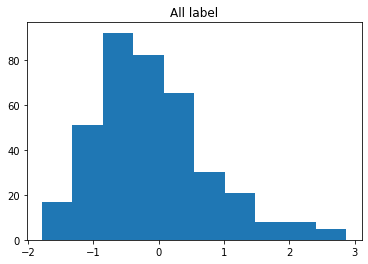

In [4]:
plt.hist(df['label'])
plt.title('All label')

(266, 7)

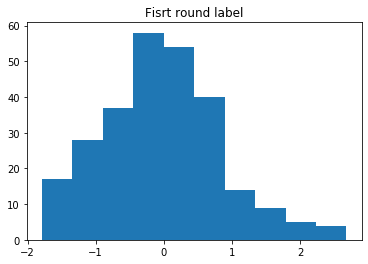

In [5]:
# extract first round result
df_FRR = df[df['Group'] == 'First round result']
plt.hist(df_FRR['label'])
plt.title('Fisrt round label')
df_FRR.shape

(113, 7)

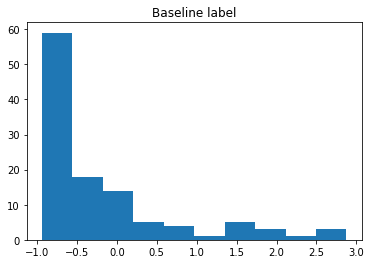

In [6]:
# extract baseline data
df_BD = df[df['Group'] == 'Baseline data']
plt.hist(df_BD['label'])
plt.title('Baseline label')
df_BD.shape

In [7]:
# data6: num_data * 2, columns: [6-base RBS seq (D), TIR labels (C)]
data = np.asarray(df[['RBS', 'label']])
data_FRR = np.asarray(df_FRR[['RBS', 'label']])
data_BD = np.asarray(df_BD[['RBS', 'label']])

In [8]:
# indicates whether cross validation (KFOLD)
cross_val_flag = False 

# indicates whether plot predict_label vs. true label
plot_flag = True 

# regression evaluation metric, 'NRMSE' or 'r2_score'
metric = 'NRMSE'

# string kernel list 
# kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw]
kernels = [sum_onehot_spectrum_kernel_pw]

models = [GaussianProcessRegressor]

# name dictionaries
regression_name = {KernelRidge: 'KR',
                  GaussianProcessRegressor: 'GPR'}
embedding_name = ['onehot', 'kmer', 'label']
kernel_name = {
               spectrum_kernel_pw: 'spec',
               #sum_spectrum_kernel_pw: 'sspec',
               sum_onehot_spectrum_kernel_pw: 'sospec',
               #mixed_spectrum_kernel_pw: 'mspec',
               #WD_kernel_pw: 'WD',
               #sum_onehot_WD_kernel_pw: 'sWD',
               #WD_shift_kernel_pw: 'WDshift'
                }

train_scores = {}
test_scores = {}
trained_reg_model_dict = {}

data_dict = {
             'all': data,
             'First round result': data_FRR,
             'Baseline data': data_BD,
             None: None
            }

alpha = 1e-10 # Value added to the diagonal of the kernel matrix during fitting. 

In [9]:
def run_regression(model, data_name, kernel, embedding, alpha, data_name_test = None):
    # when data_name_test is none, the regression is run on the data_name with splitting to 80/20
    # otherwise, the regression model is trained on data_name and tested on data_name_test
    if model == KernelRidge:
        reg = Regression(model(kernel = kernel, alpha = alpha), data_dict[data_name], data_dict[data_name_test], embedding)
    elif model == GaussianProcessRegressor:
        reg = Regression(model(kernel = PairwiseKernel(metric = kernel), alpha = alpha, normalize_y = True), data_dict[data_name], data_dict[data_name_test], embedding)
    
    key = data_name + '_' + str(data_name_test) + '_' + regression_name[model] + '_' + kernel_name[kernel] + '_' + embedding
    trained_model = reg.train()
    trained_reg_model_dict[key] = trained_model
    
    train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = plot_flag, metric = metric)
    
    
    train_scores[key] = train_score
    test_scores[key] = test_score
    print()

## Regression on individual groups

all

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function sum_onehot_spectrum_kernel_pw at 0x7f4af2256488>),
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train NRMSE: 0.12650249571606761
Test NRMSE: 0.18093368701589735

First round result

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function sum_onehot_spectrum_kernel_pw at 0x7f4af2256488>),
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train NRMSE: 0.07963604744209149
Test NRMSE: 0.16454130330362285

Baseline data

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function sum_onehot_spectrum_kernel_pw 

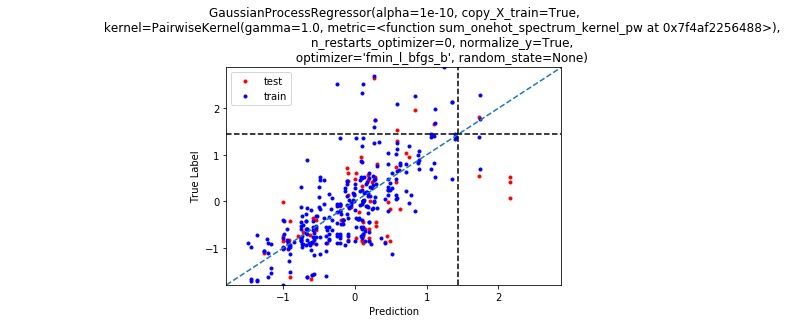

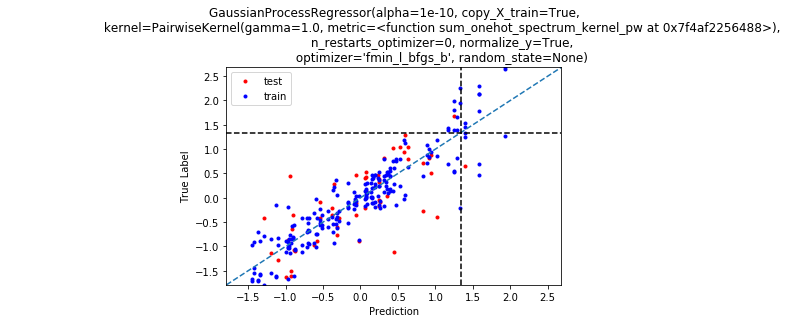

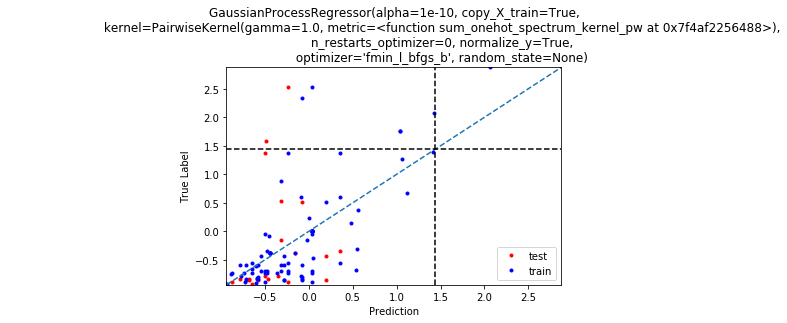

In [35]:
for data_name in data_dict.keys():
    print(data_name)
    print()
    if data_name is not None:
        for model in models:
            for kernel in kernels:
                run_regression(model, data_name, kernel, 'label', alpha)

## Regression with training on (First Round Results) FRR and testing on (Baseline) BL

Model:  GaussianProcessRegressor(alpha=1, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function sum_onehot_spectrum_kernel_pw at 0x7f4af2256488>),
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train NRMSE: 0.0993415901304343
Test NRMSE: 0.4338337738187673



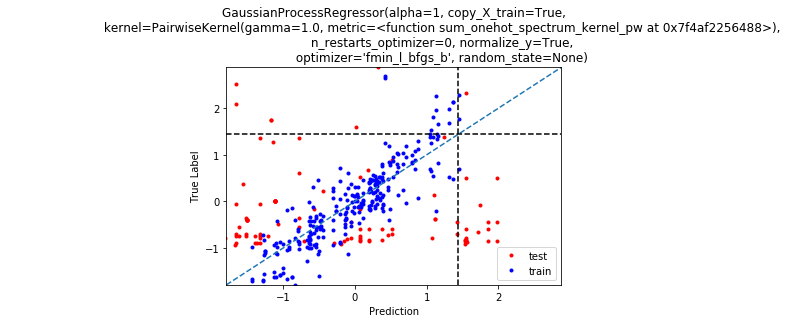

In [36]:
alpha = 1

for model in models:
    for kernel in kernels:
        run_regression(model, 'First round result', kernel, 'label', alpha, 'Baseline data')

## Regression with training on (Baseline)BL and testing on (First Round Results)FRR

Model:  GaussianProcessRegressor(alpha=1, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function sum_onehot_spectrum_kernel_pw at 0x7f4af2256488>),
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train NRMSE: 0.18222611820038312
Test NRMSE: 0.20152462407668695



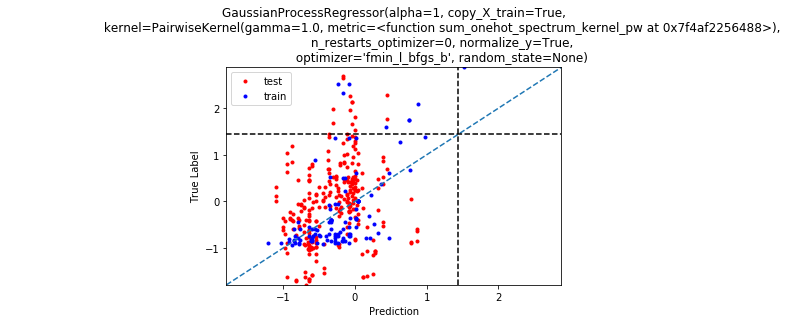

In [37]:
for model in models:
    for kernel in kernels:
        run_regression(model, 'Baseline data', kernel, 'label', alpha, 'First round result')

## Train_Rep12_Test_Rep3

The idea of this notebook is to train with Rep 1 and 2, then test with Rep 3. The label of Rep3 should inside of the confidence interval of prediction. Assuming the distribution of the replication is Gaussian,
$$p=F(\mu+n \sigma)-F(\mu-n \sigma)$$
when n = 1, p = 0.68; n = 2, p = 0.95. But since we do not have enough replications for a sequence, we evaluate the percentage using all sequences. That is, when we set n = 2, about 95% of Rep3 label of all sequences should be inside of prediction interval (well, it is not equivalent, but it's approximately correct).

In [10]:
#Path = '../../data/firstRound_4h.csv'

#df_frr = pd.read_csv(Path).dropna()
alpha_list = [1e-10, 0.01, 0.1, 0.5]

In [26]:
df.head()

,RBS,RBS6,AVERAGE,STD,variable,label,Group
0,TTTAAGAAGGAGATATACAT,AGGAGA,2.196595,0.811007,Rep1,2.648575,First round result
1,CTTAAGAAGGAGATATACAT,AGGAGA,1.288441,0.429194,Rep1,1.399539,First round result
2,GTTAAGAAGGAGATATACAT,AGGAGA,0.347877,0.118192,Rep1,0.317903,First round result
3,ATTAAGAAGGAGATATACAT,AGGAGA,1.143829,0.450811,Rep1,1.531393,First round result
4,TCTAAGAAGGAGATATACAT,AGGAGA,1.248348,0.644664,Rep1,1.386412,First round result


In [53]:
def rep_cross_predict(df, alpha_list, train_on = ['Rep1', 'Rep2'], test_on = ['Rep3'], n = 2):
    # df_Rep_train = pd.melt(df_frr[['RBS'] + train_on], id_vars = ['RBS'], value_vars = train_on)
    # data_Rep_train = np.asarray(df_Rep_train[['RBS', 'value']])

    # data_Rep_test = np.asarray(df_frr[['RBS'] + test_on])
    if len(train_on) == 1:
        data_Rep_train = np.asarray(df[df['variable'] == train_on[0]][['RBS', 'label']])
    else:
        data_Rep_train = np.asarray(df[df['variable'] == train_on[0]].append(df[df['variable'] == train_on[1]])[['RBS', 'label']])
    data_Rep_test = np.asarray(df[df['variable'] == test_on[0]][['RBS', 'label']])
    
    # plot with sorted idx average true value of first round sequences
    sorted_idx = np.argsort(df[df['variable'] == test_on[0]]['AVERAGE'])

    for model in [GaussianProcessRegressor]:
        for kernel in kernels:
            for alpha in alpha_list:
                #run_regression(model, 'Rep12', kernel, 'label', 'Rep3')

                reg = Regression(model(kernel = PairwiseKernel(metric = kernel), alpha = alpha, normalize_y = False), data_Rep_train, data_Rep_test, 'label')
                my_model = reg.train()
                mu, std = my_model.predict(reg.X_test, return_std = True)

                plt.figure()
                plt.plot(range(len(mu)), mu[sorted_idx], label='prediction', color = 'green', alpha = 0.5)
                plt.fill_between(range(len(mu)), (mu +  n * std)[sorted_idx], (mu - n * std)[sorted_idx], label = 'confidence width', color = 'orange', alpha = 0.5)
                plt.scatter(range(len(mu)), data_Rep_test[:,1][sorted_idx], label = str(test_on), color = 'blue', s =2)
                plt.title('alpha: '+str(alpha))
                plt.legend()
                plt.show()

                num_good_pred = 0
                for i,label in enumerate(data_Rep_test[:,1]):
                    if label >= mu[i] - n * std[i] and label <= mu[i] + n * std[i]:
                        num_good_pred += 1

                print('the rate of test rep labels inside of confidence width: ',float(num_good_pred)/data_Rep_test.shape[0])

                NRMSE = np.sqrt(mean_squared_error(data_Rep_test[:,1], mu))/(max(data_Rep_test[:,1]) - min(data_Rep_test[:,1]))
                print('NRMSE: ', NRMSE)

/home/mengyan/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


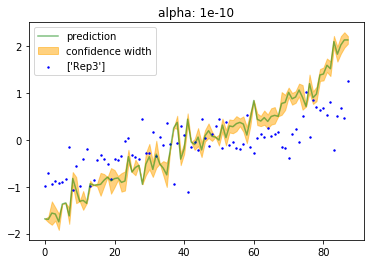

the rate of test rep labels inside of confidence width:  0.09090909090909091
NRMSE:  0.3100377787493985


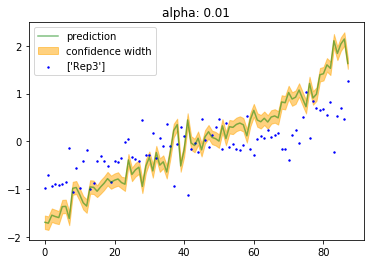

the rate of test rep labels inside of confidence width:  0.14772727272727273
NRMSE:  0.3044576592175847


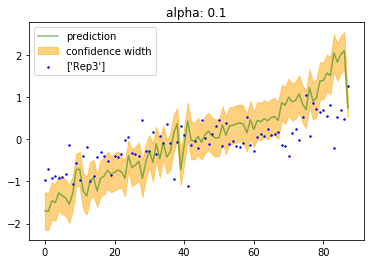

the rate of test rep labels inside of confidence width:  0.48863636363636365
NRMSE:  0.29674670325354896


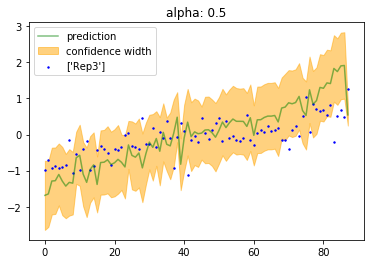

the rate of test rep labels inside of confidence width:  0.7840909090909091
NRMSE:  0.2768453403917673


In [49]:
rep_cross_predict(df, alpha_list, train_on = ['Rep1', 'Rep2'], test_on = ['Rep3'], n = 2)

/home/mengyan/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


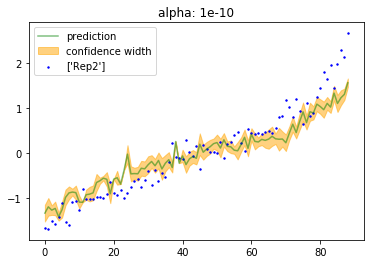

the rate of test rep labels inside of confidence width:  0.3146067415730337
NRMSE:  0.09509861373572934


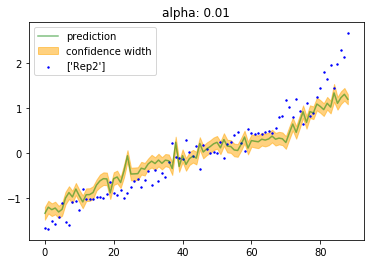

the rate of test rep labels inside of confidence width:  0.2247191011235955
NRMSE:  0.09824014208753483


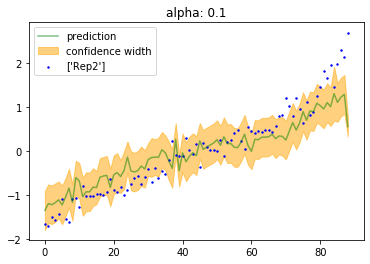

the rate of test rep labels inside of confidence width:  0.6741573033707865
NRMSE:  0.10822670915046592


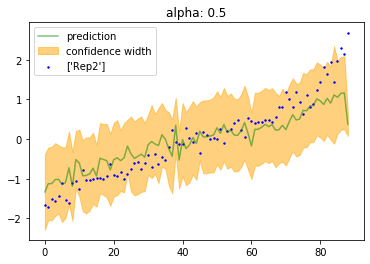

the rate of test rep labels inside of confidence width:  0.9101123595505618
NRMSE:  0.11694609286158052


In [51]:
rep_cross_predict(df, alpha_list, train_on = ['Rep1', 'Rep3'], test_on = ['Rep2'], n = 2)

/home/mengyan/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


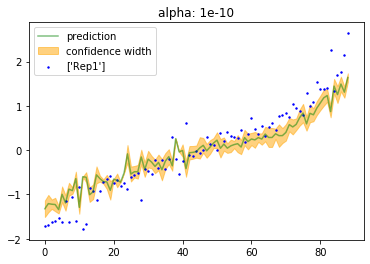

the rate of test rep labels inside of confidence width:  0.3595505617977528
NRMSE:  0.09897095320461545


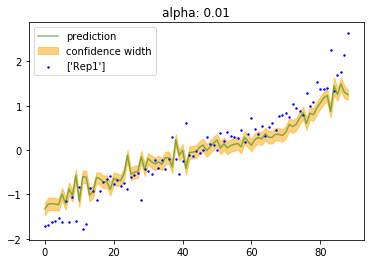

the rate of test rep labels inside of confidence width:  0.33707865168539325
NRMSE:  0.10158453774028889


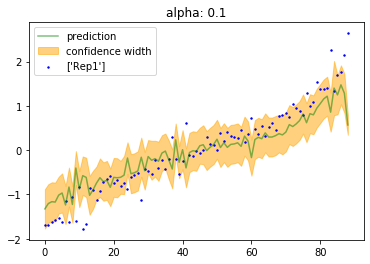

the rate of test rep labels inside of confidence width:  0.7191011235955056
NRMSE:  0.11079386373496822


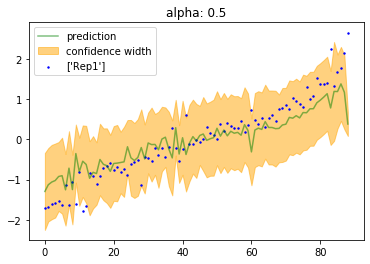

the rate of test rep labels inside of confidence width:  0.898876404494382
NRMSE:  0.11882968496965302


In [52]:
rep_cross_predict(df, alpha_list, train_on = ['Rep2', 'Rep3'], test_on = ['Rep1'], n = 2)

/home/mengyan/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


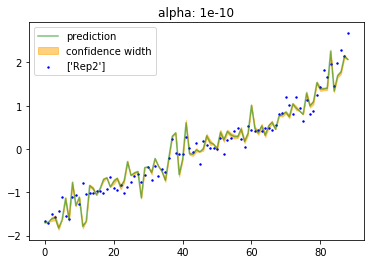

the rate of test rep labels inside of confidence width:  0.07865168539325842
NRMSE:  0.06144613220853132


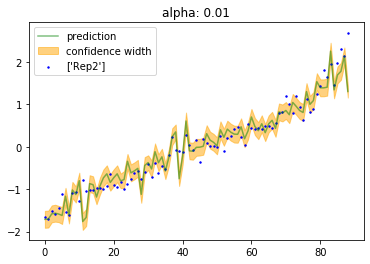

the rate of test rep labels inside of confidence width:  0.5842696629213483
NRMSE:  0.06739772155187346


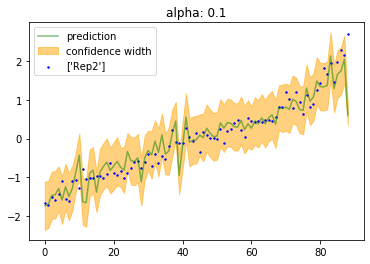

the rate of test rep labels inside of confidence width:  0.9213483146067416
NRMSE:  0.08205618931820559


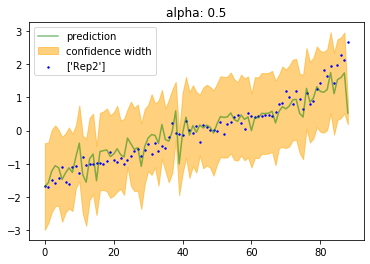

the rate of test rep labels inside of confidence width:  0.9887640449438202
NRMSE:  0.09357871403333096


In [54]:
rep_cross_predict(df, alpha_list, train_on = ['Rep1'], test_on = ['Rep2'], n = 2)

/home/mengyan/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


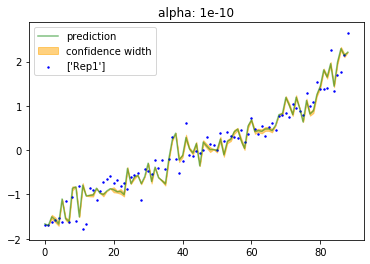

the rate of test rep labels inside of confidence width:  0.06741573033707865
NRMSE:  0.06327434639705526


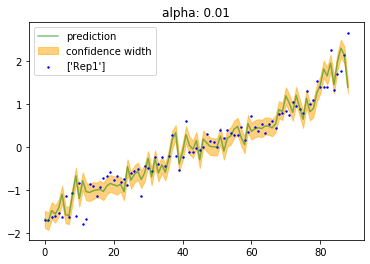

the rate of test rep labels inside of confidence width:  0.5955056179775281
NRMSE:  0.06724448310212801


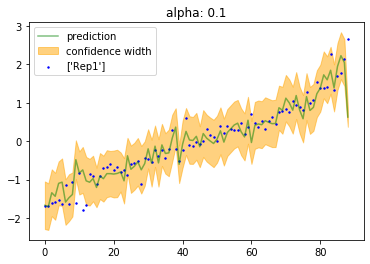

the rate of test rep labels inside of confidence width:  0.9213483146067416
NRMSE:  0.08083995311142275


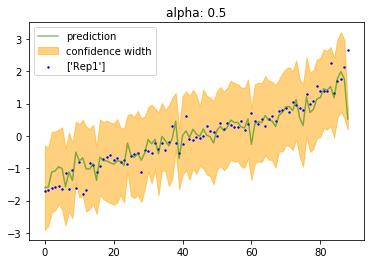

the rate of test rep labels inside of confidence width:  0.9775280898876404
NRMSE:  0.09131764760219509


In [55]:
rep_cross_predict(df, alpha_list, train_on = ['Rep2'], test_on = ['Rep1'], n = 2)

### which $\alpha$ value is good?

As $\alpha$ increases, the confidence interval is getting wider but the NRMSE is getting larger. Surprisingly, when $\alpha$ is extremely small (1e-10), the trend does not hold. When we look at the top arms (arms with top average true labels), small $\alpha$ gives a better prediction. When $\alpha > 0.1$, the predictions of top arms decrease. So the default value (1e-10) of $\alpha$ seems to be a good choice. 

## Similar arms have similar confidence interval?

Theoritically, if two arms are neighbouring, their confidence interval should be similar if they are both observed or unobserved. And if one is unobserved, then it's confidence interval should be bigger than the one observed. 

The following code cannot extactly express the idea though. Since it shows whether the similarity of arms with similar confidence interval. However, how can we sort kernel matrix?

In [41]:
model = GaussianProcessRegressor
kernel = sum_onehot_spectrum_kernel_pw
alpha = 0.5
n = 2

np.random.shuffle(data_FRR)
test_data = data_FRR
num_data = test_data.shape[0]

In [42]:
reg = Regression(model(kernel = PairwiseKernel(metric = kernel), alpha = alpha, normalize_y = True), test_data[: int(0.8 * num_data), :], test_data[int(0.8 * num_data):, :], embedding_method = 'label')
my_model = reg.train()
mu_train, std_train = my_model.predict(reg.X_train, return_std = True)
mu_test, std_test = my_model.predict(reg.X_test, return_std = True)


In [43]:
std = list(std_train) + list(std_test)

confidence_interval = n * np.asarray(std) * 2
sorted_idx = np.asarray(sorted(range(len(confidence_interval)), key=lambda k: (confidence_interval)[k]))
sorted_sorted_idx = np.argsort(sorted_idx)

observed_ci = confidence_interval[np.asarray(sorted_idx) <= int(0.8 * num_data)]
unobserved_ci = confidence_interval[np.asarray(sorted_idx) > int(0.8 * num_data)]

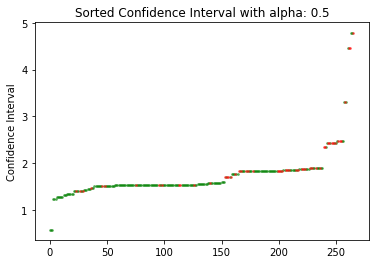

In [44]:
plt.figure()
plt.scatter(sorted_sorted_idx[np.asarray(sorted_idx) <= int(0.8 * num_data)], observed_ci, color = 'green', s = 3, alpha = 0.5)
plt.scatter(sorted_sorted_idx[np.asarray(sorted_idx) > int(0.8 * num_data)], unobserved_ci, color = 'red', s = 3, alpha = 0.5)
#plt.fill_between(range(len(mu)), mu +  n * std, mu - n * std, label = 'confidence width', color = 'orange', alpha = 0.5)
#plt.scatter(range(len(mu)), data_Rep3[:,1], label = 'Rep3 label', color = 'blue', s =2)
plt.title('Sorted Confidence Interval with alpha: '+str(alpha))
plt.ylabel('Confidence Interval')
plt.show()

In [45]:
env = Rewards_env(test_data, 'label')
kernel_matrix = np.zeros((num_data, num_data))

for i in range(num_data):
    for j in range(num_data):
        if j <= i:
            x = env.embedded[i]
            y = env.embedded[j]
            kernel_matrix[i,j] = kernel(x,y)
            
for j in range(num_data):
    for i in range(num_data):
        if j> i:
            kernel_matrix[i,j] =kernel_matrix[j,i] 

Text(0.5, 1.0, 'Kernel matrix for sorted confidence interval')

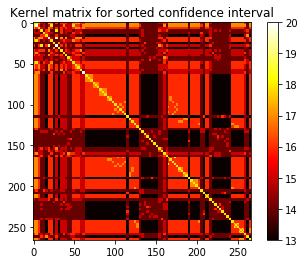

In [46]:
plt.imshow(kernel_matrix[sorted_idx, :][:, sorted_idx], cmap = 'hot', interpolation='nearest')
plt.colorbar()
plt.title('Kernel matrix for sorted confidence interval')

## Compare

Text(0.5, 1.0, 'Test Scores')

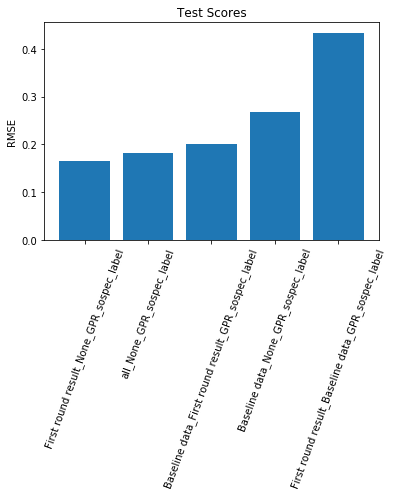

In [47]:
sorted_test_scores = sorted(test_scores.items(), key=lambda kv: kv[1])

import collections

sorted_test_scores = collections.OrderedDict(sorted_test_scores)

plt.bar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), align='center')
plt.xticks(range(len(sorted_test_scores)), list(sorted_test_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Test Scores')

## Save into file

In [48]:
import pickle

with open('trained_reg_model.pickle', 'wb') as handle:
    pickle.dump(trained_reg_model_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)